In [1]:
import collections # Handles specialized container datatypes
import cv2 # Computer vision library
import matplotlib.pyplot as plt # Plotting library
import numpy as np # Scientific computing library
import import_ipynb
import object_detection # Custom object detection program
import sys
import tensorflow as tf # Machine learning library
from tensorflow import keras # Library for neural networks
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
sys.path.append('../')

importing Jupyter notebook from object_detection.ipynb


In [2]:
def show_history(history):
  """
  Visualize the neural network model training history
   
  :param:history A record of training loss values and metrics values at 
                 successive epochs, as well as validation loss values 
                 and validation metrics values
  """
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
  plt.show()

In [3]:
def Transfer(n_classes, freeze_layers=True):
  """
  Use the InceptionV3 neural network architecture to perform transfer learning.
     
  :param:n_classes Number of classes
  :param:freeze_layers If True, the network's parameters don't change.
  :return The best neural network
  """
  print("Loading Inception V3...")
 
  # To understand what the parameters mean, do a Google search 'inceptionv3 keras'. 
  # The first search result should send you to the Keras website, which has an 
  # explanation of what each of these parameters mean.
  # input_top means we are removing the top part of the Inception model, which is the 
  # classifier. 
  # input_shape needs to have 3 channels, and needs to be at least 75x75 for the
  # resolution.
  # Our neural network will build off of the Inception V3 model (trained on the ImageNet
  # data set).
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
 
  print("Inception V3 has finished loading.")
 
  # Display the base network architecture
  print('Layers: ', len(base_model.layers))
  print("Shape:", base_model.output_shape[1:])
  print("Shape:", base_model.output_shape)
  print("Shape:", base_model.outputs)
  base_model.summary()
 
  # Create the neural network. This network uses the Sequential
  # architecture where each layer has one 
  # input tensor (e.g. vector, matrix, etc.) and one output tensor 
  top_model = Sequential()
 
  # Our classifier model will build on top of the base model
  top_model.add(base_model)
  top_model.add(GlobalAveragePooling2D())
  top_model.add(Dropout(0.5))
  top_model.add(Dense(1024, activation='relu'))
  top_model.add(BatchNormalization())
  top_model.add(Dropout(0.5))
  top_model.add(Dense(512, activation='relu'))
  top_model.add(Dropout(0.5))
  top_model.add(Dense(128, activation='relu'))
  top_model.add(Dense(n_classes, activation='softmax'))
 
  # Freeze layers in the model so that they cannot be trained (i.e. the
  # parameters in the neural network will not change)
  if freeze_layers:
    for layer in base_model.layers:
      layer.trainable = False
 
  return top_model

Images:  109
Labels:  109
Labels: Counter({2: 46, 0: 41, 3: 16, 1: 6})
0: 41
1: 6
2: 46
3: 16
Class weight: {0: 2.658536585365854, 1: 18.166666666666668, 2: 2.369565217391304, 3: 6.8125}
Loading Inception V3...
Inception V3 has finished loading.
Layers:  311
Shape: (8, 8, 2048)
Shape: (None, 8, 8, 2048)
Shape: [<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'mixed10')>]
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                      

2023-07-20 02:06:40.106914: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 66382848 exceeds 10% of free system memory.


1/8 [==>...........................] - ETA: 1:03 - loss: 12.2549 - accuracy: 0.0000e+00

2023-07-20 02:06:42.341040: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90935296 exceeds 10% of free system memory.
2023-07-20 02:06:42.510134: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 88510464 exceeds 10% of free system memory.
2023-07-20 02:06:42.915900: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.
2023-07-20 02:06:43.557394: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 54568960 exceeds 10% of free system memory.


8/8 [==============================] - ETA: 0s - loss: 13.7064 - accuracy: 0.2458
Epoch 1: val_loss improved from inf to 1.62931, saving model to traffic.h5


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 44s 5s/step - loss: 13.7064 - accuracy: 0.2458 - val_loss: 1.6293 - val_accuracy: 0.1017


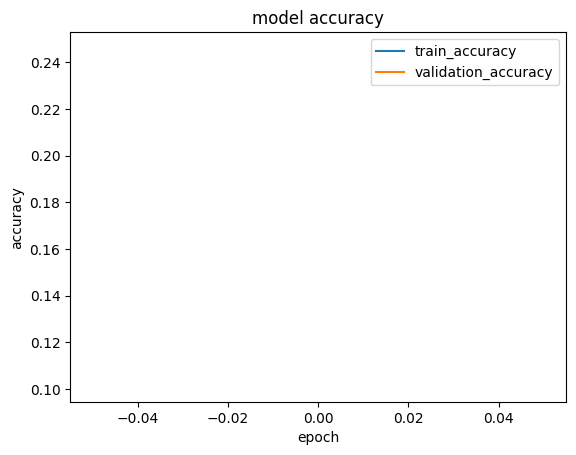

Validation loss: 1.6293094158172607
Validation accuracy: 0.10169491171836853
Saving the validation data set...
Length of the validation data set: 59
1/1 [==============================] - 0s 177ms/step
The validation data set has been saved!


In [4]:
# Perform image augmentation. 
# Image augmentation enables us to alter the available images
# (e.g. rotate, flip, changing the hue, etc.) to generate more images that our
# neural network can use for training...therefore preventing us from having to
# collect more external images.
datagen = ImageDataGenerator(rotation_range=5, width_shift_range=[-10, -5, -2, 0, 2, 5, 10],
                             zoom_range=[0.7, 1.5], height_shift_range=[-10, -5, -2, 0, 2, 5, 10],
                             horizontal_flip=True)
 
shape = (299, 299)
 
# Load the cropped traffic light images from the appropriate directory
img_0_green = object_detection.load_rgb_images("traffic_light_dataset/0_green/*", shape)
img_1_yellow = object_detection.load_rgb_images("traffic_light_dataset/1_yellow/*", shape)
img_2_red = object_detection.load_rgb_images("traffic_light_dataset/2_red/*", shape)
img_3_not_traffic_light = object_detection.load_rgb_images("traffic_light_dataset/3_not/*", shape)
 
# Create a list of the labels that is the same length as the number of images in each
# category
# 0 = green
# 1 = yellow
# 2 = red
# 3 = not a traffic light
labels = [0] * len(img_0_green)
labels.extend([1] * len(img_1_yellow))
labels.extend([2] * len(img_2_red))
labels.extend([3] * len(img_3_not_traffic_light))
 
# Create NumPy array
labels_np = np.ndarray(shape=(len(labels), 4))
images_np = np.ndarray(shape=(len(labels), shape[0], shape[1], 3))
 
# Create a list of all the images in the traffic lights data set
img_all = []
img_all.extend(img_0_green)
img_all.extend(img_1_yellow)
img_all.extend(img_2_red)
img_all.extend(img_3_not_traffic_light)
 
# Make sure we have the same number of images as we have labels
assert len(img_all) == len(labels)  
 
# Shuffle the images
img_all = [preprocess_input(img) for img in img_all]
(img_all, labels) = object_detection.double_shuffle(img_all, labels)
 
# Store images and labels in a NumPy array
for idx in range(len(labels)):
  images_np[idx] = img_all[idx]
  labels_np[idx] = labels[idx]
     
print("Images: ", len(img_all))
print("Labels: ", len(labels))
 
# Perform one-hot encoding
for idx in range(len(labels_np)):
  # We have four integer labels, representing the different colors of the 
  # traffic lights.
  labels_np[idx] = np.array(to_categorical(labels[idx], 4))
     
# Split the data set into a training set and a validation set
# The training set is the portion of the data set that is used to 
#   determine the parameters (e.g. weights) of the neural network.
# The validation set is the portion of the data set used to
#   fine tune the model-specific parameters (i.e. hyperparameters) that are 
#   fixed before you train and test your neural network on the data. The 
#   validation set helps us select the final model (e.g. learning rate, 
#   number of hidden layers, number of hidden units, activation functions, 
#   number of epochs, etc.
# In this case, 80% of the data set becomes training data, and 20% of the
# data set becomes validation data.
idx_split = int(len(labels_np) * 0.8)
x_train = images_np[0:idx_split]
x_valid = images_np[idx_split:]
y_train = labels_np[0:idx_split]
y_valid = labels_np[idx_split:]
 
# Store a count of the number of traffic lights of each color
cnt = collections.Counter(labels)
print('Labels:', cnt)
n = len(labels)
print('0:', cnt[0])
print('1:', cnt[1])
print('2:', cnt[2])
print('3:', cnt[3])
 
# Calculate the weighting of each traffic light class
class_weight = {0: n / cnt[0], 1: n / cnt[1], 2: n / cnt[2], 3: n / cnt[3]}
print('Class weight:', class_weight)
 
# Save the best model as traffic.h5
checkpoint = ModelCheckpoint("traffic.h5", monitor='val_loss', mode='min', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(min_delta=0.0005, patience=15, verbose=1)
 
# Generate model using transfer learning
model = Transfer(n_classes=4, freeze_layers=True)
 
# Display a summary of the neural network model
model.summary()
 
# Generate a batch of randomly transformed images 
it_train = datagen.flow(x_train, y_train, batch_size=32)
 
# Configure the model parameters for training
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(
  lr=1.0, rho=0.95, epsilon=1e-08), metrics=['accuracy'])
 
# Train the model on the image batches for a fixed number of epochs
# Store a record of the error on the training data set and metrics values
#   in the history object.
history_object = model.fit(it_train, epochs=10, validation_data=(
  x_valid, y_valid), shuffle=True, callbacks=[
  checkpoint, early_stopping], class_weight=class_weight)
 
# Display the training history
show_history(history_object)
 
# Get the loss value and metrics values on the validation data set
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
 
print('Saving the validation data set...')
 
print('Length of the validation data set:', len(x_valid))
 
# Go through the validation data set, and see how the model did on each image
for idx in range(len(x_valid)):
 
  # Make the image a NumPy array
  img_as_ar = np.array([x_valid[idx]])
 
  # Generate predictions    
  prediction = model.predict(img_as_ar)
 
  # Determine what the label is based on the highest probability
  label = np.argmax(prediction)
 
  # Create the name of the directory and the file for the validation data set
  # After each run, delete this out_valid/ directory so that old files are not
  # hanging around in there.
  file_name = "output_validation_set/" + str(idx) + "_" + str(label) + "_" + str(np.argmax(str(y_valid[idx]))) + ".jpg"
  img = img_as_ar[0]
 
  # Reverse the image preprocessing process
  img = object_detection.reverse_preprocess_inception(img)
 
  # Save the image file
  cv2.imwrite(file_name, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
 
print('The validation data set has been saved!') 